#**1. Import Monitored Data and Make DatrFrame(df_mon)**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
# '/content/gdrive/My Drive/Colab Notebooks/pi_digits.txt'
with open('/content/gdrive/My Drive/Colab Notebooks/mon_standard.pkl', 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Mounted at /content/gdrive
Loading datafile...
Total samples: 19000


feature를 배열 형태로 추출

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들었습니다
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})


In [ ]:
df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


In [ ]:
df_mon.tail()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
18995,9434,8815,619,0.934386,0.065614,23,7,43.91,214.848554,94
18996,9956,9404,552,0.944556,0.055444,23,7,15.60,638.205128,94
18997,9952,9373,579,0.941821,0.058179,22,8,14.93,666.577361,94
18998,9926,9236,690,0.930486,0.069514,23,7,19.91,498.543446,94
18999,9925,9168,757,0.923728,0.076272,23,7,13.76,721.293605,94


# **2. Decision Tree**

## **2-1. Train/Test split**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [ ]:
#   column number
#   0: total packets,	1: #of incoming packets, 2:	#of outgoing packets
#   3: ratio of incoming packets, 4: ratio of outgoing packets
#   5: #of incoming(first30), 6: #of outgoing(first30), 7: total time, 8: #of packets per sec

# 이 부분을 고쳐서 model train에 사용할 feature를 고르고 accuracy를 확인 가능

'''
## Case 1: All the features - accuracy score:  0.5423684210526316    <----- best
## Case 2: Top 5 feautures - accuracy score:  0.4392105263157895
## Case 3: Top 5 features + no.5 + no.6 - accuracy score:  0.5839473684210527
## Case 4: Top 5 features + no.7 + no.8 - accuracy score:  0.5676315789473684
'''
test1 = [0,1,2,3,4,5,6,7,8]
test2 = [0,1,2,3,4]
test3 = [0,1,2,3,4,5,6]
test4 = [0,1,2,3,4,7,8]
X = df_mon.iloc[:, test1]
y = df_mon['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## **2-2. model training and testing (print accuracy score and classification report)**



```
모든 Feature 사용 확정. 최적의 hyperparameter를 찾기 위해 Grid Search 결과

<Case 1>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
최적 매개 변수: {'criterion': 'entropy', 'max_depth': None} <---- best
테스트 세트 정확도: 0.5844736842105264

<Case 2>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
최적 매개 변수: {'criterion': 'entropy', 'max_depth': 10}
테스트 세트 정확도: 0.4392105263157895

<Case 3>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
최적 매개 변수: {'criterion': 'entropy', 'max_depth': None}
테스트 세트 정확도: 0.541578947368421

<Case 4>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
최적 매개 변수: {'criterion': 'entropy', 'max_depth': None}
테스트 세트 정확도: 0.4926315789473684

```



In [ ]:
#Grid Search
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Decision Tree Classifier 객체 생성
dt_classifier = DecisionTreeClassifier()

# 탐색할 매개 변수 그리드 설정
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
}

# GridSearchCV를 사용하여 최적의 매개 변수 탐색
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# 최적의 매개 변수 출력
print("최적 매개 변수:", grid_search.best_params_)

# 최적의 매개 변수를 사용한 모델
best_dt_model = grid_search.best_estimator_

# 테스트 세트로 모델 평가
accuracy = best_dt_model.score(X_test, y_test)
print("테스트 세트 정확도:", accuracy)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
최적 매개 변수: {'criterion': 'entropy', 'max_depth': None}
테스트 세트 정확도: 0.5802631578947368


"\n<Case 1>\nFitting 5 folds for each of 6 candidates, totalling 30 fits\n최적 매개 변수: {'criterion': 'entropy', 'max_depth': None} <---- best\n테스트 세트 정확도: 0.5844736842105264\n\n<Case 2>\nFitting 5 folds for each of 6 candidates, totalling 30 fits\n최적 매개 변수: {'criterion': 'entropy', 'max_depth': 10}\n테스트 세트 정확도: 0.4392105263157895\n\n<Case 3>\nFitting 5 folds for each of 6 candidates, totalling 30 fits\n최적 매개 변수: {'criterion': 'entropy', 'max_depth': None}\n테스트 세트 정확도: 0.541578947368421\n\n<Case 4>\nFitting 5 folds for each of 6 candidates, totalling 30 fits\n최적 매개 변수: {'criterion': 'entropy', 'max_depth': None}\n테스트 세트 정확도: 0.4926315789473684\n"

In [ ]:
Dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, random_state=0)
Dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred = Dtree.predict(X_test)
print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred)))
precision = precision_score(y_test, y_pred, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred, labels=list(range(95))))


Accuracy on test dataset: 0.5828947368421052
Precision on test dataset: 0.5828947368421052
              precision    recall  f1-score   support

           0       0.49      0.50      0.49        38
           1       0.51      0.43      0.47        42
           2       0.65      0.73      0.69        41
           3       0.63      0.55      0.59        40
           4       0.57      0.67      0.62        30
           5       0.62      0.60      0.61        35
           6       0.75      0.73      0.74        33
           7       0.64      0.70      0.67        43
           8       0.65      0.72      0.68        36
           9       0.68      0.58      0.62        52
          10       0.51      0.48      0.49        44
          11       0.43      0.45      0.44        40
          12       0.69      0.79      0.74        39
          13       0.42      0.37      0.39        41
          14       0.46      0.55      0.50        33
          15       0.57      0.57      0.57 

## **2-3. Testset 분류 결과 및 plot을 이용한 시각화**

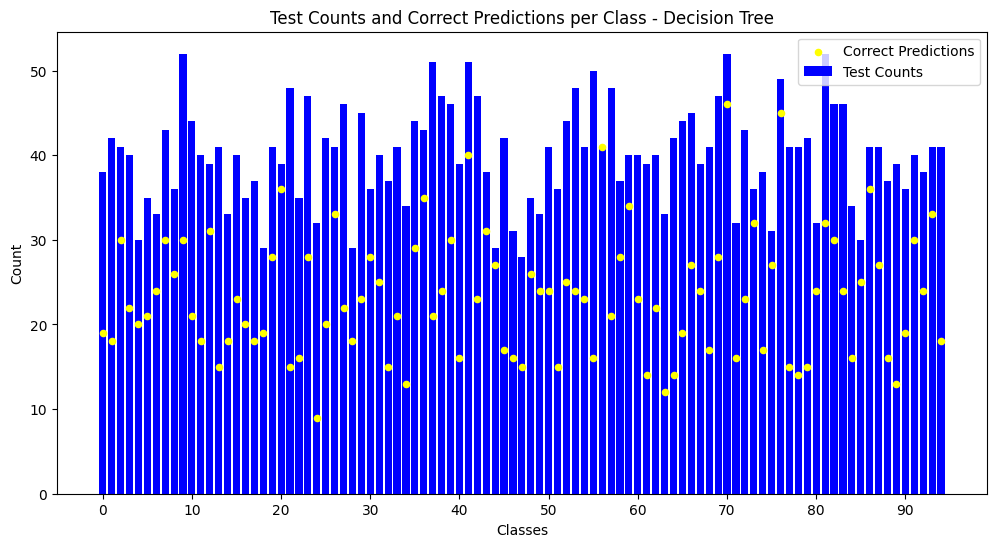

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 각 클래스별 테스트 데이터 개수 계산
test_counts = Counter(y_test)

# 각 클래스별로 예측이 맞은 데이터 개수 계산
correct_predictions = (y_test == y_pred)
correct_counts = Counter(y_test[correct_predictions])

# 클래스 범위
num_classes = 95
classes = np.arange(num_classes)

# 각 클래스별 테스트 데이터 개수를 막대 그래프로 표시
plt.figure(figsize=(12, 6))  # 그래프 크기 조절
plt.bar(classes, [test_counts[i] for i in classes], color='blue', label='Test Counts')

# 예측이 맞은 데이터 개수를 점으로 표시
plt.scatter(classes, [correct_counts[i] if i in correct_counts else 0 for i in classes], color='yellow', label='Correct Predictions', s=20)
plt.xticks(np.arange(0, num_classes, 10))

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Test Counts and Correct Predictions per Class - Decision Tree')
plt.legend()
plt.show()

# **3. Decision Tree - More Detailed Classification Results** ❌ 실제 분류에 decision tree 사용하지 않기로 함


#### **(1) True Class, Predicted Class, 예측 성공 여부, 'True Class'에 부여된 확률, 'True Class'의 가능성 순위 출력 및 배열에 저장**
```
< 출력 예시 >
Test Data 3799 - True Class: 3, Predicted Class: 3
★ Correct Prediction
Predicted Class 3: 0.9574468085106383
Predicted Class 37: 0.02127659574468085
Predicted Class 78: 0.02127659574468085
Predicted Class 94: 0.0
Predicted Class 33: 0.0
Predicted Class 25: 0.0
Predicted Class 26: 0.0
Predicted Class 27: 0.0
Predicted Class 28: 0.0
Predicted Class 29: 0.0
▷ Predicted Probability for True Class (3): 0.9574468085106383
▷ Rank of True Class Probability: 1
```

In [ ]:
probabilities = Dtree.predict_proba(X_test)
sorted_indexes = np.argsort(probabilities, axis=1)

true_class_prob_array = [] # 모델이 계산한 실제 클래스의 확률
true_class_rank_array = [] # 실제 클래스의 예측된 확률 순위 (크기순)
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class: {pred_class}")
    if true_class == pred_class:
      print("★ Correct Prediction") # 올바르게 분류한 경우만 출력
    for index in sorted_index[::-1][:10]: # 확률 상위 10개 class만 출력
        print(f"Predicted Class {index}: {probabilities[i][index]}")
    true_class_prob = probabilities[i][true_class]  # 실제 클래스에 대한 예측된 확률
    true_class_prob_array.append(true_class_prob)  # 배열에 추가
    true_class_rank = np.where(sorted_index[::-1] == true_class)[0][0] + 1  # 실제 클래스의 순위
    true_class_rank_array.append(true_class_rank)  # 배열에 추가
    print(f"▷ Predicted Probability for True Class ({true_class}): {true_class_prob}")
    print(f"▷ Rank of True Class Probability: {true_class_rank}")
    print()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Predicted Class 63: 0.1
Predicted Class 29: 0.1
Predicted Class 61: 0.1
Predicted Class 14: 0.1
Predicted Class 24: 0.1
Predicted Class 94: 0.0
Predicted Class 32: 0.0
Predicted Class 26: 0.0
▷ Predicted Probability for True Class (39): 0.2
▷ Rank of True Class Probability: 2

Test Data 3457 - True Class: 71, Predicted Class: 71
★ Correct Prediction
Predicted Class 71: 0.4375
Predicted Class 9: 0.25
Predicted Class 63: 0.09375
Predicted Class 78: 0.0625
Predicted Class 0: 0.03125
Predicted Class 27: 0.03125
Predicted Class 30: 0.03125
Predicted Class 35: 0.03125
Predicted Class 31: 0.03125
Predicted Class 32: 0.0
▷ Predicted Probability for True Class (71): 0.4375
▷ Rank of True Class Probability: 1

Test Data 3458 - True Class: 45, Predicted Class: 11
Predicted Class 11: 0.4375
Predicted Class 19: 0.4375
Predicted Class 62: 0.0625
Predicted Class 45: 0.0625
Predicted Class 42: 0.0
Predicted Class 32: 0.0
Predicted Class 26: 0.0
Predicted Class 27: 0

#### **(2) (3)을 위한 작업...**
#### *가능성 1위 라벨의 확률, 가능성 2위 라벨의 확률을 correct/wrong case로 나눠 배열에 저장, 평균을 출력, plot을 그려 분포를 확인*
```
<출력 예시>
1st Largest Probability avgerage (Correct case):  0.7236819936520547
2nd Largest Probability avgerage (Correct case):  0.127625767731041
1st Largest Probability avgerage (Wrong case):  0.5051299678539176
2nd Largest Probability avgerage (Correct case):  0.20347996479985667
```



In [ ]:
first_proba_c =[] # 1위 확률 (예측 성공 케이스)
second_proba_c =[] # 2위 확률 (예측 성공 케이스)
first_proba_w =[] # 1위 확률 (예측 실패 케이스)
second_proba_w =[] # 2위 확률 (예측 실패 케이스)
proba_gap_c = [] # 예측 성공시 (1위 확률 - 2위 확률)을 저장
proba_gap_w = [] # 예측 실패시 (1위 확률 - 2위 확률)을 저장
proba_ratio_c = [] # 예측 성공시 (1위 확률 / 2위 확률)을 저장
proba_ratio_w =[] # 예측 실패시 (1위 확률 / 2위 확률)을 저장


# correct, wrong 관계없이
proba_top = [] # 1위 확률들만 저장
proba_gap = [] # 1위 확률 - 2위 확률 저장
proba_ratio = [] # 1위 확률 / 2위 확률 저장
tf_label = [] # correct / wrong 여부 저장 correct = 1, wrong = 0 저장
# 따라서 위 4개 배열에는 모든 test case (3800개)의 해당값을 저장

#각 테스트 데이터에 대해 확률 배열과 실제 클래스를 함께 출력
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    # print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class {pred_class}")
    # for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
    #   print(f"Predicted Class {index}: {probabilities[i][index]}")
    first_proba = probabilities[i][sorted_index[-1]] # 1위 확률
    second_proba = probabilities[i][sorted_index[-2]] # 2위 확률
    proba_top.append(first_proba) # proba_top 는 1위 확률들을 모아놓은 배열
    proba_gap.append(first_proba - second_proba) # proba_gap 은 1위확률 - 2위확률 값들을 저장
    proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
    if true_class == pred_class:
        first_proba_c.append(first_proba)  # 1위 확률 저장 (plot출력용)
        second_proba_c.append(second_proba) # 2위 확률 저장
        proba_gap_c.append(first_proba - second_proba)
        proba_ratio_c.append(first_proba/second_proba)
        tf_label.append(1)

    else:
      first_proba_w.append(first_proba)  # 가장 큰 확률 저장
      second_proba_w.append(second_proba)
      proba_gap_w.append(first_proba - second_proba)
      proba_ratio_w.append(first_proba/second_proba)
      tf_label.append(0)
    #print()

print("1st Largest Probability avgerage (Correct case): ", sum(first_proba_c)/len(first_proba_c))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_c)/len(second_proba_c))
print("1st Largest Probability avgerage (Wrong case): ", sum(first_proba_w)/len(first_proba_w))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_w)/len(second_proba_w))

1st Largest Probability avgerage (Correct case):  0.7236819936520547
2nd Largest Probability avgerage (Correct case):  0.127625767731041
1st Largest Probability avgerage (Wrong case):  0.5051299678539176
2nd Largest Probability avgerage (Correct case):  0.20347996479985667


<ipython-input-13-0dbdf69da5f5>:27: RuntimeWarning: divide by zero encountered in double_scalars
  proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
<ipython-input-13-0dbdf69da5f5>:32: RuntimeWarning: divide by zero encountered in double_scalars
  proba_ratio_c.append(first_proba/second_proba)
<ipython-input-13-0dbdf69da5f5>:39: RuntimeWarning: divide by zero encountered in double_scalars
  proba_ratio_w.append(first_proba/second_proba)


#### **(3) '-1'을 부여할 기준 찾기 (unmonitored data에서 0~94에 속하지 않는 data 구별)**


##### **방법 1**: 1위 라벨에 부여된 확률의 크기 분포 (및 plot을 이용해 시각화)



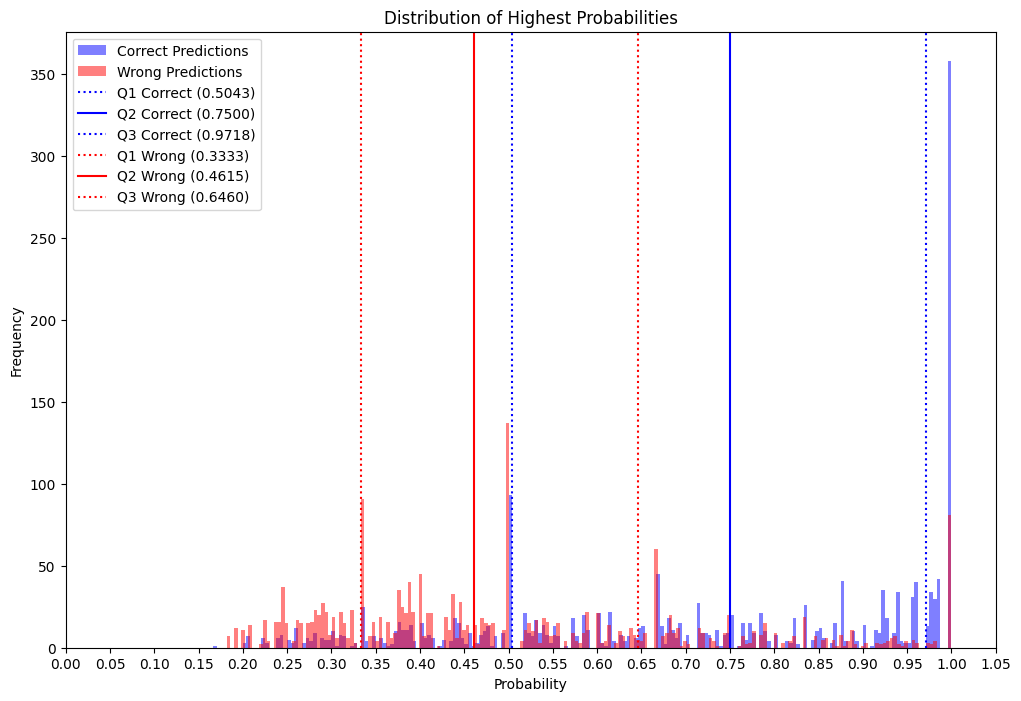

In [ ]:
import matplotlib.pyplot as plt

q1_first_proba_c = np.percentile(first_proba_c, 25)
q2_first_proba_c = np.percentile(first_proba_c, 50)
q3_first_proba_c = np.percentile(first_proba_c, 75)

q1_first_proba_w = np.percentile(first_proba_w, 25)
q2_first_proba_w = np.percentile(first_proba_w, 50)
q3_first_proba_w = np.percentile(first_proba_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(first_proba_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(first_proba_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_first_proba_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_first_proba_c:.4f})')
plt.axvline(x=q2_first_proba_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_first_proba_c:.4f})')
plt.axvline(x=q3_first_proba_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_first_proba_c:.4f})')

plt.axvline(x=q1_first_proba_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_first_proba_w:.4f})')
plt.axvline(x=q2_first_proba_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_first_proba_w:.4f})')
plt.axvline(x=q3_first_proba_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_first_proba_w:.4f})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Highest Probabilities')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 2**: 1위, 2위 라벨에 부여된 확률 차이의 분포 (및 plot을 이용해 시각화)


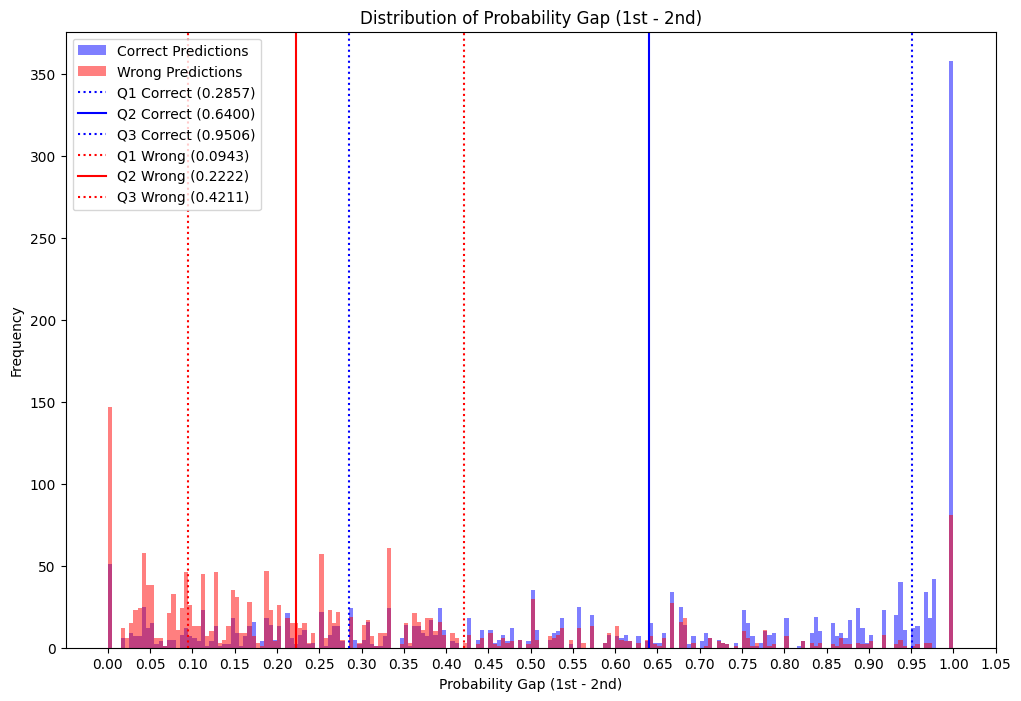

In [ ]:
# proba_gap_c와 proba_gap_w의 상위 25%, 50%, 하위 25% 값을 계산
q1_gap_c = np.percentile(proba_gap_c, 25)
q2_gap_c = np.percentile(proba_gap_c, 50)
q3_gap_c = np.percentile(proba_gap_c, 75)
q1_gap_w = np.percentile(proba_gap_w, 25)
q2_gap_w = np.percentile(proba_gap_w, 50)
q3_gap_w = np.percentile(proba_gap_w, 75)

# proba_ratio_w와 proba_ratio_w의 상위 25%, 하위 25% 값을 계산
q1_ratio_c = np.percentile(proba_ratio_c, 25)
q2_ratio_c = np.percentile(proba_ratio_c, 50)
q3_ratio_c = np.percentile(proba_ratio_c, 75)
q1_ratio_w = np.percentile(proba_ratio_w, 25)
q2_ratio_w = np.percentile(proba_ratio_w, 50)
q3_ratio_w = np.percentile(proba_ratio_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(proba_gap_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_gap_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_gap_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_gap_c:.4f})')
plt.axvline(x=q2_gap_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_gap_c:.4f})')
plt.axvline(x=q3_gap_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_gap_c:.4f})')

plt.axvline(x=q1_gap_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_gap_w:.4f})')
plt.axvline(x=q2_gap_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_gap_w:.4f})')
plt.axvline(x=q3_gap_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_gap_w:.4f})')

plt.xlabel('Probability Gap (1st - 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Gap (1st - 2nd)')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 3**: 1위, 2위 라벨에 부여된 확률의 비율(1st/2nd) 분포 (및 plot을 이용해 시각화) ❌

ValueError: ignored

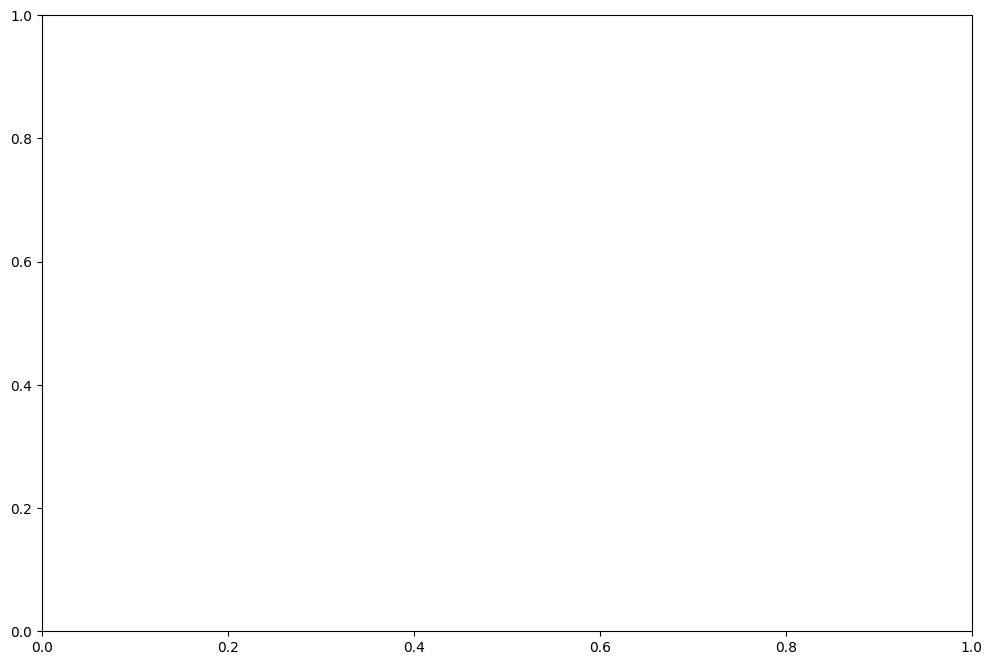

In [ ]:
'''
np_arr = np.array(proba_ratio_c)
finite_values = np_arr[np.logical_and(np.isfinite(np_arr), np_arr != np.inf)]
proba_ratio_c = finite_values.tolist
'''
plt.figure(figsize=(12, 8))
plt.hist(proba_ratio_c, bins=2000, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_ratio_w, bins=4000, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_ratio_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_ratio_c:.4f})')
plt.axvline(x=q2_ratio_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_ratio_c:.4f})')
plt.axvline(x=q3_ratio_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_ratio_c:.4f})')

plt.axvline(x=q1_ratio_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_ratio_w:.4f})')
plt.axvline(x=q2_ratio_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_ratio_w:.4f})')
plt.axvline(x=q3_ratio_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_ratio_w:.4f})')

plt.xlabel('Probability Ratio (1st / 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Ratio (1st / 2nd)')
plt.legend()
plt.xlim(0, 15) # x축 값 15 이상은 제외함 ()
plt.xticks(np.arange(0, 15.1, 0.5))  # x축 눈금을 0부터 15까지 0.5 단위로 설정
plt.show()

##### **방법 1,2,3에 대한 분석** : *best threshold*를 찾고, accuracy, precision, recall, f1-score, confusion matirx 출력
```
<출력 예시>
Best Threshold (gap criterion): 0.22241558645547072
Best F1-score: 0.6087551299589603
Confusion Matrix:
[[2783  188]
 [ 384  445]]
Accuracy: 0.8495
Precision: 0.7030
Recall: 0.5368
```

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 가능한 임계값 생성
p_thresholds = np.unique(proba_top)  # proba_top에서 중복되지 않는 값들을 임계값으로 설정

best_p_f1 = -1
best_p_threshold = None

# 모든 임계값에 대해 F1-score 계산
for p_threshold in p_thresholds:
    predicted_label = (proba_top >= p_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_p_f1:
        best_p_f1 = f1
        best_p_threshold = p_threshold

print("Best Threshold (largest probability criterion):", best_p_threshold)
print("Best F1-score:", best_p_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_top >= best_p_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (largest probability criterion): 0.29196807262386726
Best F1-score: 0.7677212655186224
Confusion Matrix:
[[ 723  858]
 [ 302 1917]]
Accuracy: 0.6947
Precision: 0.6908
Recall: 0.8639


In [ ]:
# 방법 2

# 가능한 임계값 생성
g_thresholds = np.unique(proba_gap)  # proba_gap에서 중복되지 않는 값들을 임계값으로 설정

best_g_f1 = -1
best_g_threshold = None

# 모든 임계값에 대해 F1-score 계산
for g_threshold in g_thresholds:
    predicted_label = (proba_gap >= g_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_g_f1:
        best_g_f1 = f1
        best_g_threshold = g_threshold

print("Best Threshold (gap criterion):", best_g_threshold)
print("Best F1-score:", best_g_f1)
from sklearn.metrics import confusion_matrix

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_gap >= best_g_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (gap criterion): 0.22241558645547072
Best F1-score: 0.6087551299589603
Confusion Matrix:
[[2783  188]
 [ 384  445]]
Accuracy: 0.8495
Precision: 0.7030
Recall: 0.5368
